In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
import os
import random
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix

In [17]:
def split_data(data, features, target):
    """Split on test/train/val.

    Args:
        df (pd.DataFrame): input dataset
        features (list): list of features
        target (str): target column name
    Returns:
        tuple: X_train, X_test, y_train, y_test, X_val, y_val
    """
    # Split on test/train 80/20
    # split startified on target
    X_train, X_test, y_train, y_test = train_test_split(
        data[features], data[target], test_size=0.3, random_state=1
    )
    # make validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=1
    )
    return X_train, X_test, y_train, y_test, X_val, y_val


def train_model(model, X_train, y_train, X_test, y_test, X_val, y_val):
    """Train model and return predictions.

    Args:
        model (sklearn model): model to train
        X_train (pd.DataFrame): training data
        y_train (pd.DataFrame): training labels
        X_test (pd.DataFrame): test data
        y_test (pd.DataFrame): test labels
        X_val (pd.DataFrame): validation data
        y_val (pd.DataFrame): validation labels

    Returns:
        tuple: mae, model
    """
    from sklearn.metrics import mean_absolute_error

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    # Evaluaate
    mae = mean_absolute_error(y_val, y_pred)
    return 


In [18]:
df = pd.read_csv('forward_selection_AIC_ahi_c0h4a.csv')
target="ahi_c0h4a"
df["ahi_c0h4a"]

0        4.314248
1       23.406593
2        4.853556
3        2.591362
4        5.513514
          ...    
5799    21.669196
5800    17.901391
5801     5.625000
5802     6.971570
5803    29.411765
Name: ahi_c0h4a, Length: 5804, dtype: float64

In [19]:
features = ['neck20', 'bmi_s1', 'age_s1', 'gender', 'diasbp', 'funres02', 'shhs1_tcvd', 'ess_s1', 'nonsp_st', 'hosnr02', 'benzod1', 'ccb1', 'nsrrid', 'shhs1_qc', 'twuweh02', 'race', 'estrgn1', 'waist', 'soda15', 'tea15', 'urdbpae', 'diuret1', 'pvdl1', 'height', 'weight', 'systbp']

In [20]:
model = Ridge(alpha=4.434528937795567, random_state=1, solver='sparse_cg')

In [21]:
X_train, X_test, y_train, y_test, X_val, y_val = split_data(df, features, target)

In [22]:
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
# Evaluaate
mae = mean_absolute_error(y_val, y_pred)

# Find out the top 5 errors

In [24]:
errors = abs(y_pred - y_val)

# Convert to DataFrame for easier analysis
error_df = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred, 'Error': errors})

# Sort by error to find high-error instances
high_error_df = error_df.sort_values(by='Error', ascending=False)

# Analyze high-error instances
print(high_error_df.head())

         Actual  Predicted      Error
1647  65.422741  12.030181  53.392559
1934  54.389857  13.024822  41.365035
5047  54.976744  16.635178  38.341566
4313  54.292035  17.974559  36.317477
2224  48.496552  12.867608  35.628944


# Get details of the top 5 errors

In [28]:
high_error_indices = error_df.sort_values(by='Error', ascending=False).index
original_rows = df.loc[high_error_indices]

print(original_rows.head())

      neck20     bmi_s1  age_s1  gender  diasbp  funres02  shhs1_tcvd  ess_s1  \
1647    42.0  26.964344    74.0     1.0    63.0       2.0         0.0     0.0   
1934    43.5  27.331351    61.0     2.0    86.0       4.0         0.0    14.0   
5047    44.0  39.581806    62.0     2.0    67.0       2.0         0.0    11.2   
4313    45.0  34.907341    59.0     1.0    84.0       3.0         0.0     8.0   
2224    38.0  23.148789    76.0     1.0    69.0       2.0         0.0     6.0   

      nonsp_st  hosnr02  ...   waist  soda15  tea15       urdbpae  diuret1  \
1647       0.0      4.0  ...  102.00     0.0    0.0 -8.673617e-19      0.0   
1934       0.0      8.0  ...   90.00     0.0    0.0 -8.673617e-19      1.0   
5047       0.4      3.0  ...  123.00     1.0    1.0 -8.673617e-19      0.0   
4313       0.0      4.0  ...  106.68     1.0    0.0 -8.673617e-19      1.0   
2224       0.0      1.0  ...  108.00     3.0    0.0 -8.673617e-19      0.0   

      pvdl1   height  weight  systbp  ahi_c0

# Plot error distribution with top 5% errors hightlighted

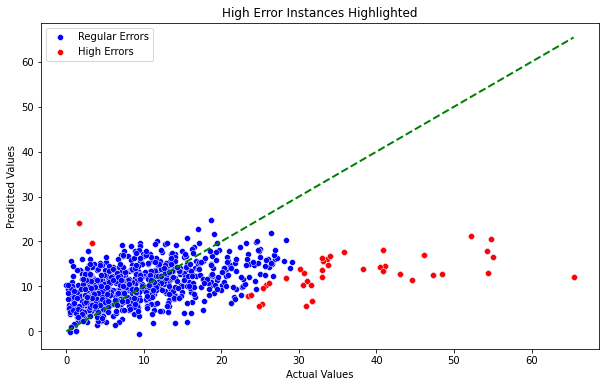

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
threshold = np.percentile(error_df['Error'], 95)
high_error_df = error_df[error_df['Error'] >= threshold]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=error_df, color='blue', label='Regular Errors')
sns.scatterplot(x='Actual', y='Predicted', data=high_error_df, color='red', label='High Errors')
plt.plot([error_df['Actual'].min(), error_df['Actual'].max()], 
         [error_df['Actual'].min(), error_df['Actual'].max()], 
         color='green', lw=2, linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('High Error Instances Highlighted')
plt.legend()
plt.show()

# Plot error distribution

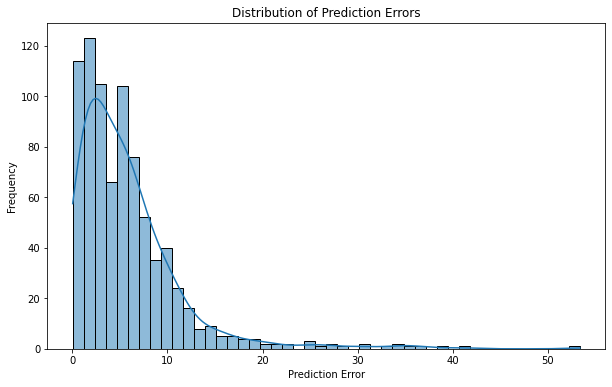

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(error_df['Error'], kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

# Examine distributions of high-error instances. Compare with the original distribution in plots.

In [38]:
high_error_data = df.loc[high_error_df.index]

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


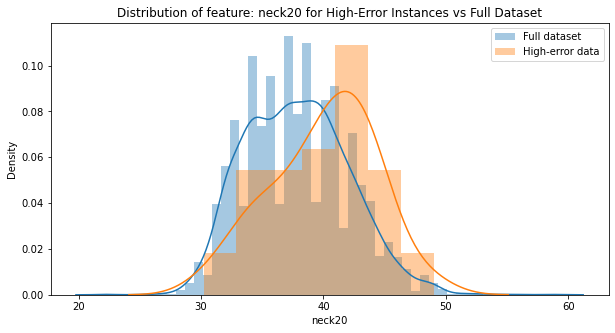

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


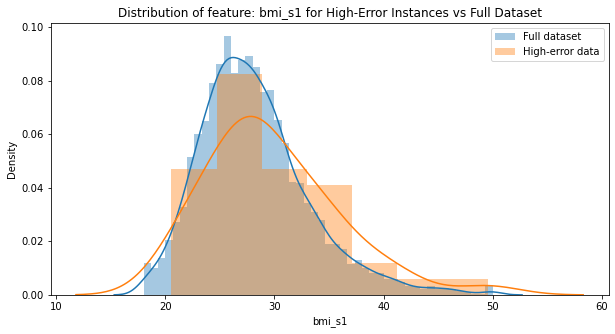

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


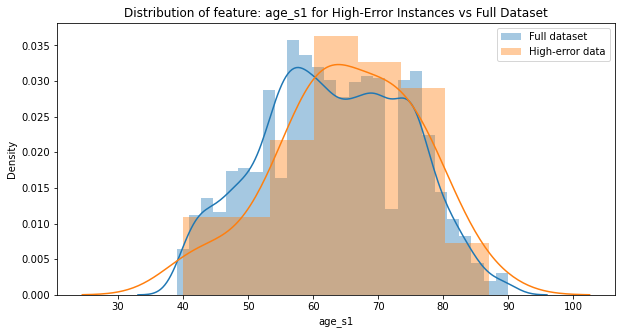

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


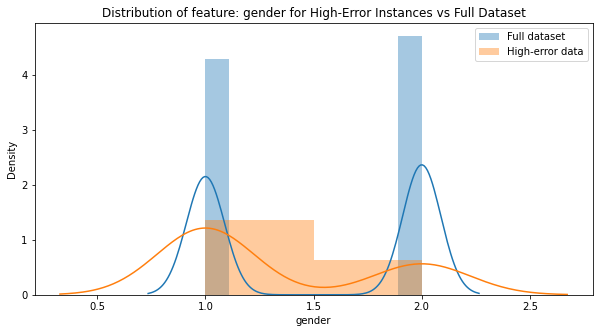

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


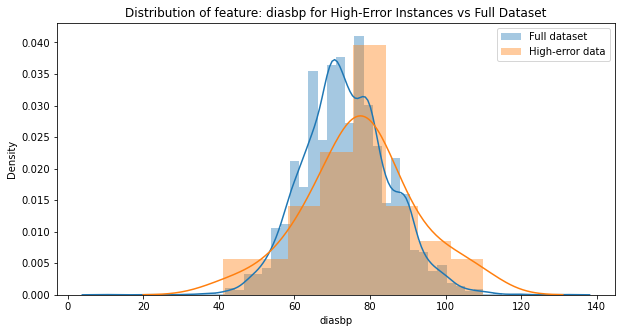

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


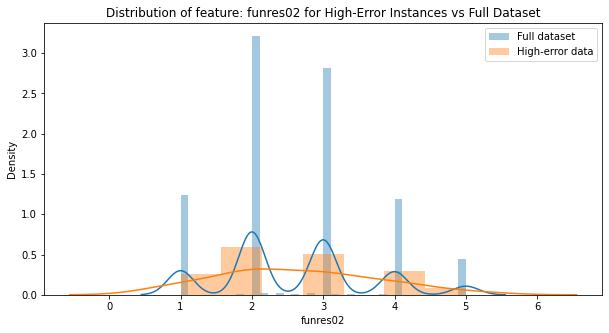

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


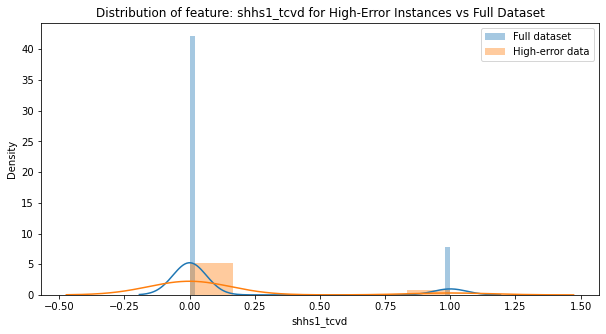

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


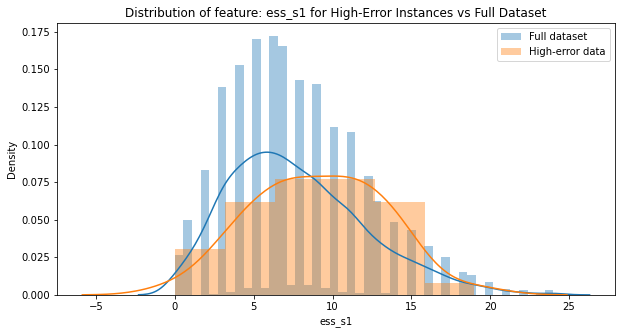

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


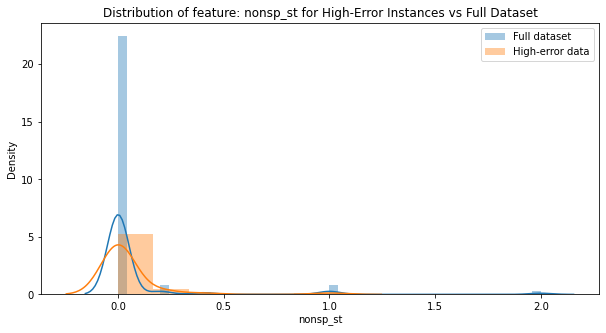

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


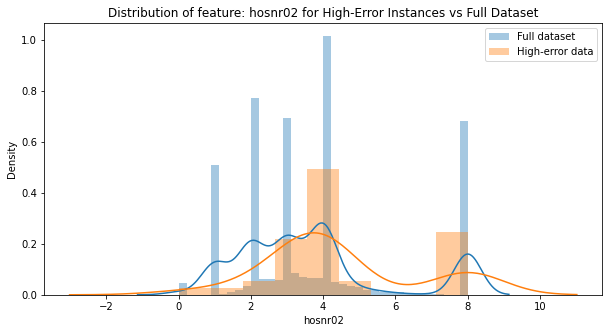

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


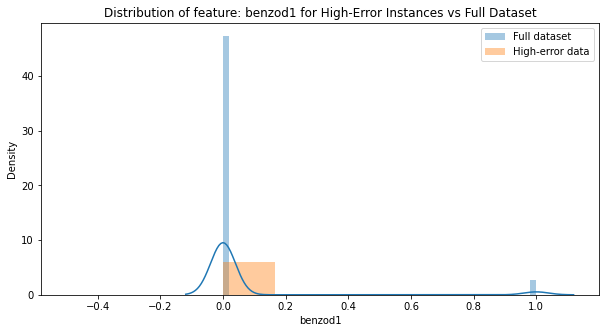

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


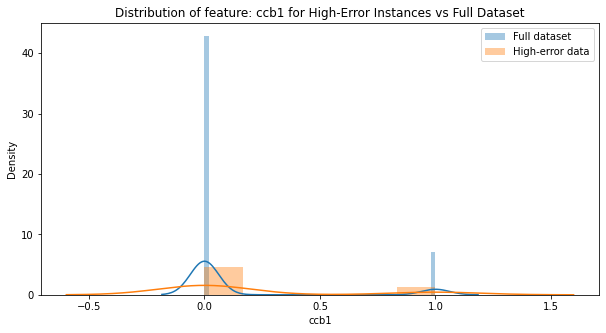

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


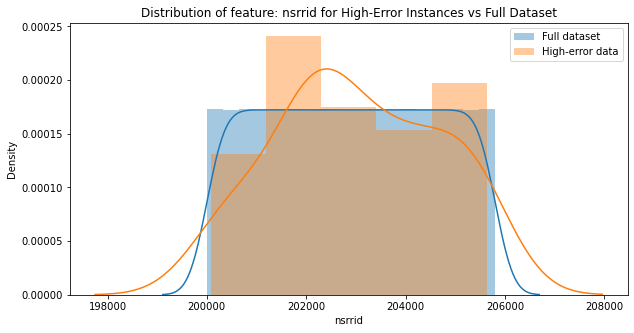

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


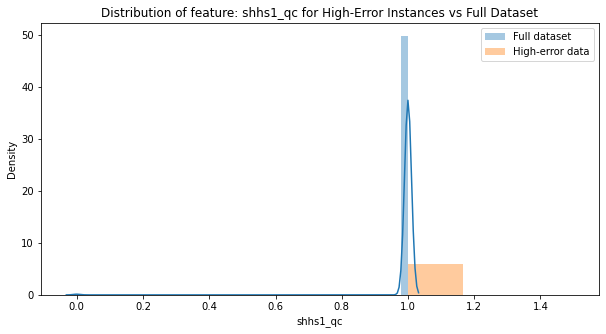

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


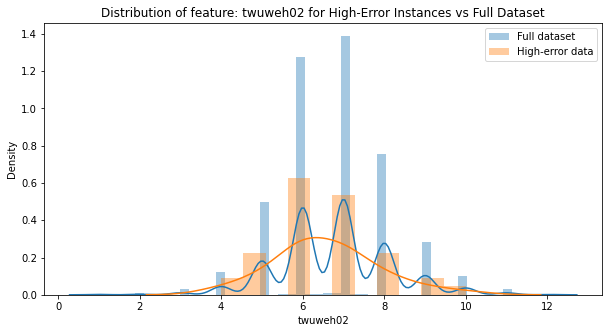

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


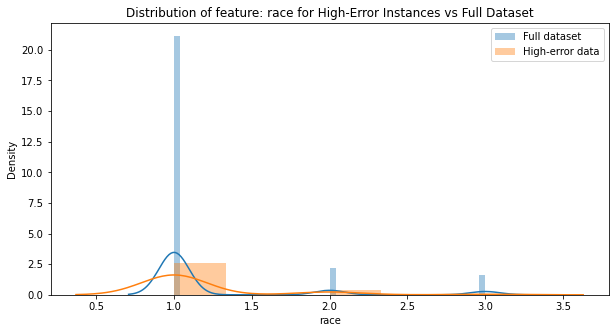

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


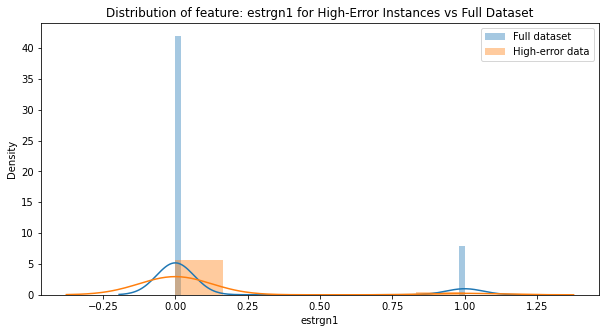

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


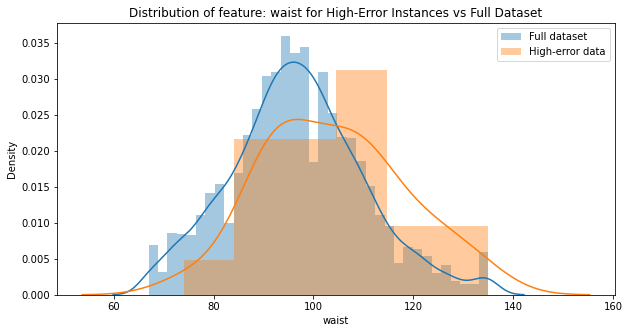

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


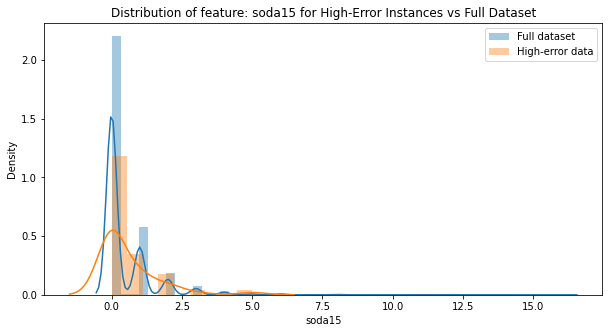

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


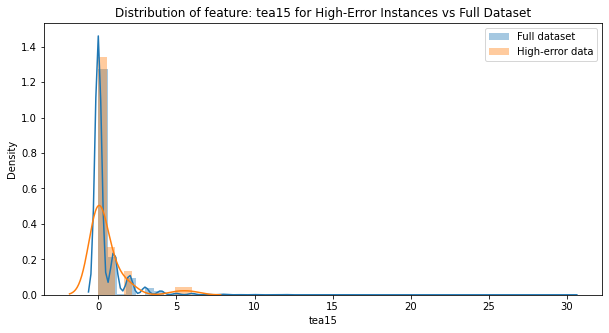

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


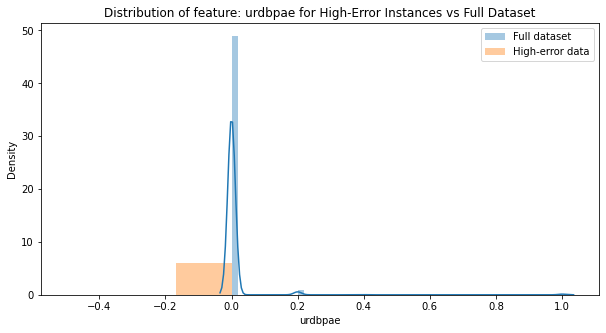

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


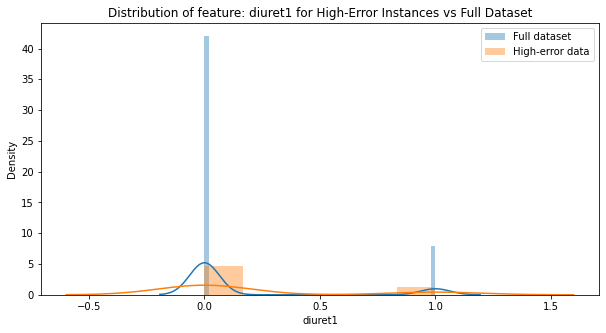

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


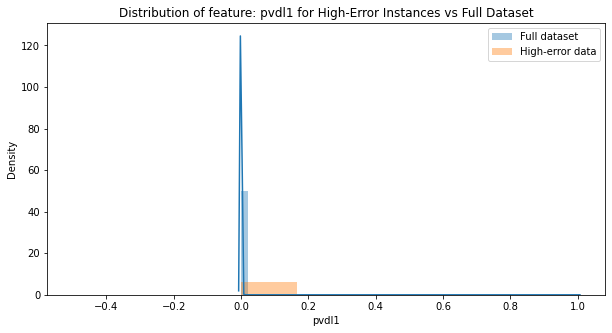

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


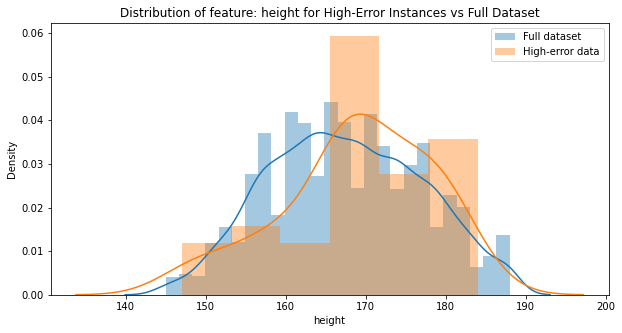

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


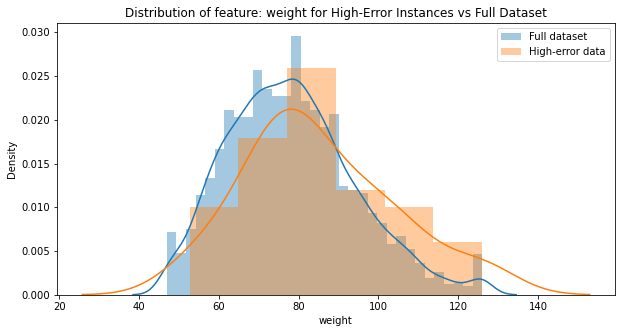

C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\minyu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


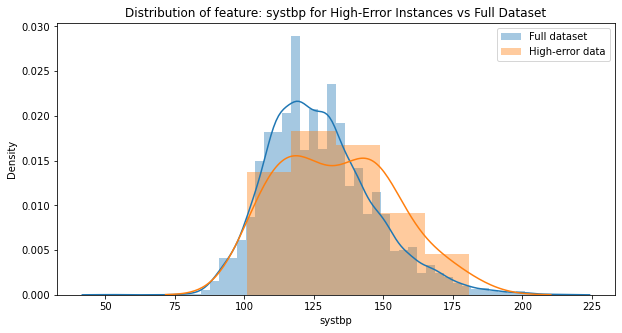

In [39]:
for column in df.columns[:-1]:  # Assuming the last column is the target
    plt.figure(figsize=(10, 5))
    sns.distplot(df[column], label='Full dataset')
    sns.distplot(high_error_data[column], label='High-error data')
    plt.legend()
    plt.title(f'Distribution of feature: {column} for High-Error Instances vs Full Dataset')
    plt.show()

# Examine high error instances with P-Value

In [42]:
from scipy.stats import ks_2samp

for column in df.columns[:-1]:  # Assuming the last column is the target
    statistic, p_value = ks_2samp(df[column], high_error_data[column])
    if p_value > 0.05:
        print(f'Feature: {column}, K-S statistic: {statistic}, P-value: {p_value}')

Feature: bmi_s1, K-S statistic: 0.16192785463347398, P-value: 0.21165846824248602
Feature: age_s1, K-S statistic: 0.1523759896454926, P-value: 0.27207079490187513
Feature: gender, K-S statistic: 0.20653124001949874, P-value: 0.05318201554030877
Feature: diasbp, K-S statistic: 0.1693365382999109, P-value: 0.17229353598187724
Feature: funres02, K-S statistic: 0.03843018271671345, P-value: 0.9999997574067665
Feature: shhs1_tcvd, K-S statistic: 0.03466490729690205, P-value: 0.9999999937456505
Feature: ess_s1, K-S statistic: 0.1940209443445227, P-value: 0.08108043265759435
Feature: nonsp_st, K-S statistic: 0.03332857070817435, P-value: 0.9999999987257021
Feature: benzod1, K-S statistic: 0.053583735354927636, P-value: 0.999380963263282
Feature: ccb1, K-S statistic: 0.07857491049066245, P-value: 0.9459203910835124
Feature: nsrrid, K-S statistic: 0.1258635760030929, P-value: 0.4993544136014413
Feature: shhs1_qc, K-S statistic: 0.003618194348725017, P-value: 1
Feature: twuweh02, K-S statistic: 